# Bitcoin return prediction 

This is a simple notebook that attempts to use machine learning and cross validation to predict whether the bitcoin price will move up or down in the next 30 minutes. I attempt to use a meaningful cross validation strategy to avoid look ahead bias. 

This notebook is more of a test and doodle than an actual project.

## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data and basic statistics

In [2]:
df = pd.read_csv('btc_data.csv')
df = df.set_index(df.ts)
df.index = pd.to_datetime(df.index)
df.head()

,ts,open,high,low,close,vol,close_ts,qavol,n_trades,base_vol,quote_vol,ignore
ts,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,7195.24,7196.25,7178.20,7180.97,202.942868,1577837699999,1.458245e+06,2452,76.962041,553069.534929,0
2020-01-01 00:15:00,2020-01-01 00:15:00,7180.97,7186.40,7175.47,7178.45,128.242654,1577838599999,9.207027e+05,1948,58.389110,419226.471447,0
2020-01-01 00:30:00,2020-01-01 00:30:00,7178.19,7185.44,7176.23,7179.56,83.487458,1577839499999,5.994792e+05,1580,43.822374,314667.321072,0
2020-01-01 00:45:00,2020-01-01 00:45:00,7179.35,7183.98,7175.46,7177.02,97.141921,1577840399999,6.974298e+05,1660,46.979601,337325.862203,0
2020-01-01 01:00:00,2020-01-01 01:00:00,7176.47,7194.04,7175.71,7190.86,103.520522,1577841299999,7.440891e+05,1588,56.251378,404330.498386,0


In [3]:
# start by dropping unnecessary cols
df = df.drop(['ts', 'close_ts', 'qavol', 'base_vol', 'quote_vol', 'ignore'], axis = 1)

df.shape

(105069, 6)

In [4]:
df.describe()

,open,high,low,close,vol,n_trades
count,105069.000000,105069.000000,105069.000000,105069.000000,105069.000000,105069.000000
mean,28869.634577,28949.120755,28787.668998,28869.721587,996.567091,20803.001542
std,17100.143729,17150.633589,17048.118666,17100.055815,1252.334250,23261.376460
min,3888.650000,4240.750000,3782.130000,3882.220000,0.000000,0.000000
25%,11622.870000,11640.190000,11603.640000,11622.960000,345.894870,7373.000000
50%,23670.520000,23748.000000,23601.370000,23670.530000,588.281822,12577.000000
75%,42977.220000,43093.570000,42854.010000,42977.210000,1147.339379,24908.000000
max,68718.890000,69000.000000,68480.000000,68718.900000,40371.405060,442735.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105069 entries, 2020-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   open      105069 non-null  float64
 1   high      105069 non-null  float64
 2   low       105069 non-null  float64
 3   close     105069 non-null  float64
 4   vol       105069 non-null  float64
 5   n_trades  105069 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 5.6 MB


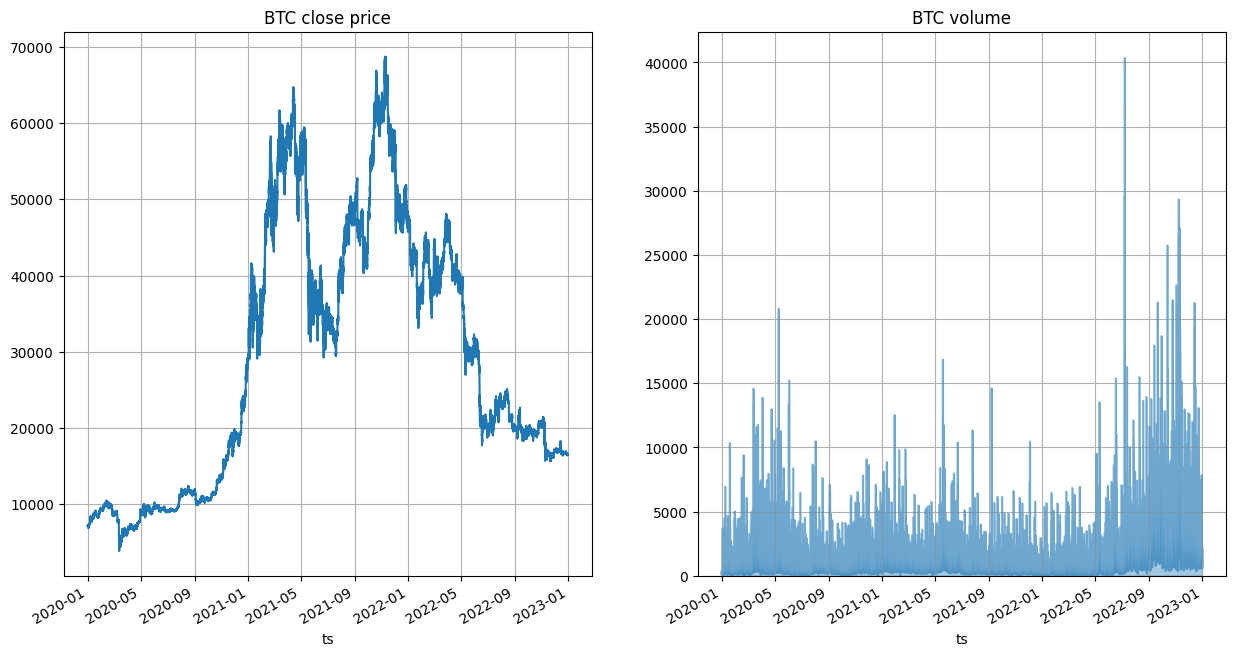

In [6]:
# lets plot the close and vol over time

fig, ax = plt.subplots(ncols = 2, figsize = (15, 8))

df.close.plot(title = 'BTC close price', grid = True, ax = ax[0])
df.vol.plot.area(title = 'BTC volume', grid = True, ax = ax[1], alpha = 0.4)
plt.show()

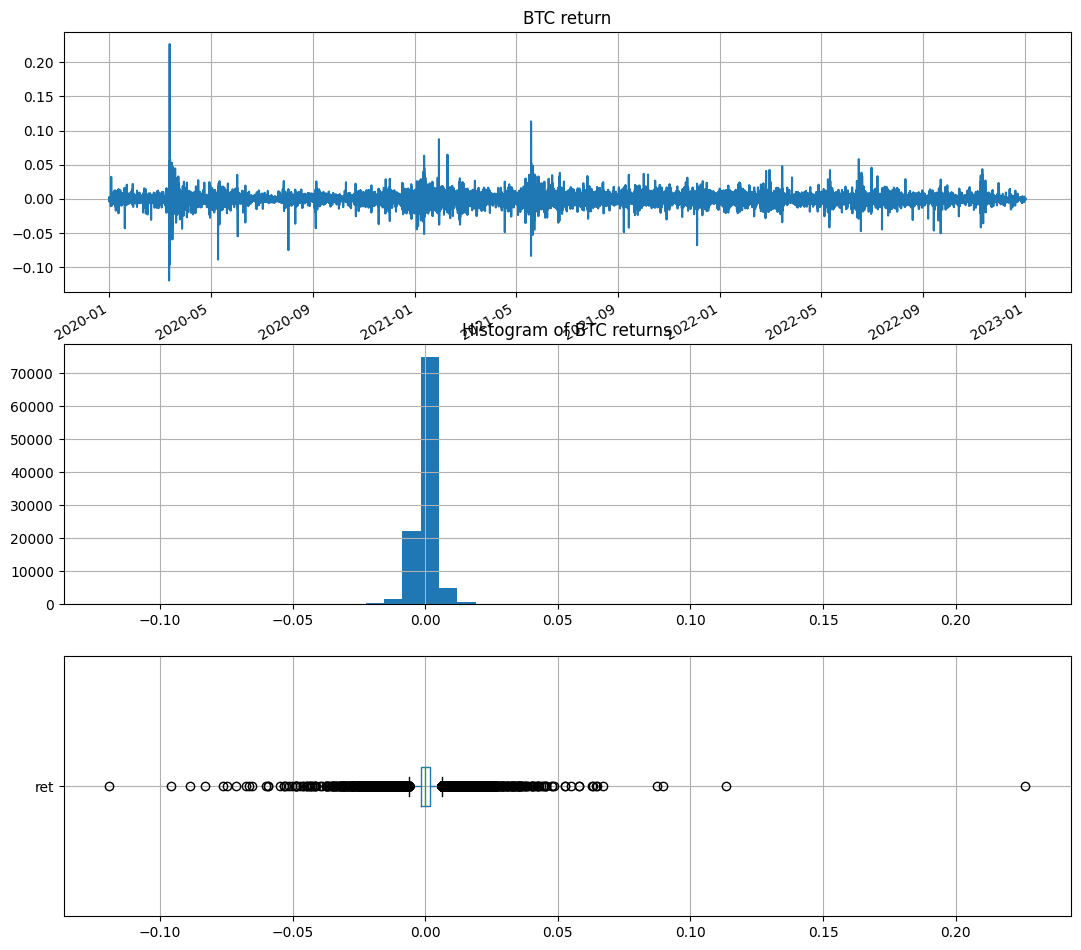

In [7]:
# create new feature return
df['ret'] = df.close.pct_change().fillna(0)

fig, ax = plt.subplots(nrows = 3, figsize = (13, 13))

df.ret.plot(title = 'BTC return', grid = True, ax = ax[0])
df.ret.hist(ax = ax[1], bins = 50)
ax[1].set_title('Histogram of BTC returns')
df.boxplot('ret', vert = False, ax = ax[2])

plt.show()

We can see we have some severe outliers that distort how the plots look. 

Lets create our target variable. We will try to predict 30 minutes into the future whether the price will have gone up or down. 

## Feature Engineering

I will create some features that might add some information for the model to learn.

In [8]:
# add dummy if return is negative or positive over the next 30 minutes
df['fut_ret'] = (df['ret'] + 1).rolling(2).apply(np.prod).shift(-2)
df['target'] = np.where(df.fut_ret > 1, 1, 0)

df.head(10)

,open,high,low,close,vol,n_trades,ret,fut_ret,target
ts,,,,,,,,,
2020-01-01 00:00:00,7195.24,7196.25,7178.20,7180.97,202.942868,2452,0.000000,0.999804,0
2020-01-01 00:15:00,7180.97,7186.40,7175.47,7178.45,128.242654,1948,-0.000351,0.999801,0
2020-01-01 00:30:00,7178.19,7185.44,7176.23,7179.56,83.487458,1580,0.000155,1.001574,1
2020-01-01 00:45:00,7179.35,7183.98,7175.46,7177.02,97.141921,1660,-0.000354,1.004888,1
2020-01-01 01:00:00,7176.47,7194.04,7175.71,7190.86,103.520522,1588,0.001928,1.002922,1
2020-01-01 01:15:00,7190.46,7217.00,7189.23,7212.10,251.543052,2472,0.002954,1.000578,1
2020-01-01 01:30:00,7212.10,7230.00,7207.17,7211.87,387.247252,3203,-0.000032,1.000014,1
2020-01-01 01:45:00,7212.34,7216.41,7204.28,7216.27,140.741777,1770,0.000610,1.001638,1
2020-01-01 02:00:00,7215.52,7223.80,7211.41,7211.97,133.760653,1699,-0.000596,1.003558,1


In [9]:
# create feature as ratio of high to low
df['ratio_hl'] = df['high'] / df['low']

# rolling volatility of last 2 hours
df['vola'] = df.ret.rolling(8).std()

df = df.dropna()

## EDA

I will now analyze relationships between variables and our target. 

MISSING

## Create a model

I will use pipeline to create and try different models.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [11]:
# split X and y
X = df.drop(['target', 'fut_ret'], axis = 1)
y = df.loc[:, 'target']

# create correct cv split for time series to avoid look ahead bias
tscv = TimeSeriesSplit(n_splits = 10)

# create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression())
])

# evaluate model
scores = cross_val_score(pipeline, X, y, cv = tscv)
np.mean(scores)

0.519193717277487

In [12]:
# a priori we are trying to beat
df.target.sum() / len(df)

0.504778221968399

This is actually already off to a very good start. Around 50% of all observations have a positive return after 30 minutes. We are able to beat this with our simple linear regression. 

Lets try something more fancy.

In [13]:
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

scores = cross_val_score(pipeline2, X, y, cv = tscv)
np.mean(scores)

0.5019790575916231

Interestingly, the accuracy is worse!

Lets try XGBoost.

In [14]:
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier())
])

scores = cross_val_score(pipeline3, X, y, cv = tscv)
np.mean(scores)

0.5184502617801047

It seems that logistic regression had the best results. For the purpose of this project I will not invest too much time in optimizing XGBoost. However, I will at some point delve more into the algorithm.

For now, I will use a simple grid search to potentially increase the accuracy of the XGBoost model. 

In [15]:
#setting grid of selected parameters for iteration
param_grid = {'model__learning_rate': [0.01, 0.1, 0.25],
              'model__max_depth': [4, 8, 12],
              'model__n_estimators': [20, 30, 40]}

gs_xgb = GridSearchCV(estimator = pipeline3, 
             param_grid = param_grid, 
             scoring = 'accuracy', 
             return_train_score = False, 
             verbose = 1, 
             cv = tscv,
             n_jobs = -1)

gs_xgb.fit(X, y)
gs_xgb.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


{'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 40}

In [16]:
gs_xgb.best_score_

0.5204712041884817

We improved the accuracy of the model.